[< Back to the main notebook](./index.md)

# Detour no.3: Getting the Airbnb data

> This is a rendered version of a Jupyter notebook. The source notebook can be found [in my GitHub repository](https://github.com/barjin/ndbi023-project), along with the data used in this analysis.

In this notebook, we will download the Airbnb data for the city of Prague. We will use the [Airbnb Scraper](https://apify.com/tri_angle/airbnb-scraper) from Apify, which is a web scraping tool that allows us to extract data from the Airbnb website. The data will be saved in a CSV file, which we will then use in the next notebook to analyze the Airbnb listings in Prague.

After setting up the scraper, we will run it to collect the data. We download the data in the form of a JSON file.

The collected data corresponds to a query between `2024-12-02` and `2024-12-07`.

In [1]:
import pandas as pd

df = pd.read_json('./data/airbnb/dataset_airbnb-scraper_2024-05-09_14-52-46-874.json')

After loading the raw JSON data into a pandas DataFrame, we will perform some initial data exploration to understand the structure of the data and identify any potential issues that need to be addressed.

We can start by removing the columns with only one unique value, as they don't provide any information and are likely to be just artifacts of the data collection process.

In [4]:
import numpy as np
import json

uniques = pd.DataFrame(columns=['column', 'unique_values'])

for col in df.columns:
    try:
        uniques = uniques._append({'column': col, 'unique_values': df[col].map(lambda x: json.dumps(x)).nunique()}, ignore_index=True)
    except:
        uniques = uniques._append({'column': col, 'unique_values': np.Infinity}, ignore_index=True)

uniques.sort_values(by='unique_values', ascending=True)

df = df.drop(columns=uniques[uniques['unique_values'] == 1]['column'].values.tolist())

print("Dropped columns: ", uniques[uniques['unique_values'] == 1]['column'].values.tolist())


Dropped columns:  ['reviews', 'isAvailable', 'isNewListing', 'tierId', 'hasSpecialOffer', 'hasWeWorkLocation', 'isBusinessTravelReady', 'hometourSections', 'initialDescriptionAuthorType', 'country', 'countryCode', 'hasHostGuidebook', 'hasLocalAttractions', 'neighborhoodCommunityTags', 'paidGrowthRemarketingListingIds', 'hasCommercialHostInfo', 'reviewsOrder', 'nearbyAirportDistanceDescriptions', 'renderTierId', 'showReviewTag', 'pointOfInterests', 'chinaPointsOfInterestMatcha', 'pageViewType', 'previewTags', 'seeAllHometourSections', 'enableHighlightsVoting', 'heroModule', 'availabilityModule', 'sortedReviews', 'documentDisplayPictures', 'sections', 'metadata', 'paidGrowthRemarketingListingIdsStr']


By looking at the names of the dropped columns, we can see that they are usually related to the location of the listing (which has been used as the initial filter - we're only scraping listings in Prague) or some advanced features of the Airbnb platform (like the `isBusinessTravelReady` column), which are simply not that popular in the listings.

Analyizng the remaining columns, we can remove some more of them - the scraper has collected a lot of information, but we're not going to use all of it in our analysis. We can drop columns containing personal information about the hosts (even though this would be interesting for a more in-depth analysis, e.g. to see whether some hosts hoard properties), as well as some columns that are not relevant to our analysis (like the `listingUrl` or `listingId`).

Finally, we can save the cleaned data to a CSV file, which we will use in the next notebook to analyze the Airbnb listings in Prague.

In [5]:
# Drop columns containing personal information
df = df.drop(columns=['primaryHost', 'additionalHosts', 'id', 'photos'])

# Drop columns containing free text fields
df = df.drop(columns=['additionalHouseRules', 'hostGuidebook', 'sectionedDescription', 'descriptionLocale', 'localizedCity', 'localizedListingExpectations', 'state'])

# Drop columns containing low-relevancy (or deeply structured) data
df = df.drop(columns=['localizedCheckOutTime', 'localizedCheckInTimeWindow', 'accessibilityModule', 'categorizedPreviewAmenities', 'hasHouseRules', 'highlights', 'highlightsImpressionId', 'hometourRooms', 'isRepresentativeInventory', 'listingExpectations', 'roomType', 'seeAllAmenitySections', 'listingRooms'])

# Drop columns containing some more miscellaneous
df = df.drop(columns=['p3ImpressionId', 'p3SummaryAddress', 'rootAmenitySections', 'priceDetails'])

This process leaves us with a handful of columns that contain our main features of interest, such as the price, the number of reviews, the number of guests the listing can accommodate, and the number of bedrooms and bathrooms.

Many of those features are sadly still buried in some data hierarchies, so we will need to extract them into separate columns. We will also need to convert some of the columns to the appropriate data types, such as integers or floats.

In [6]:
# parsing out longitude and latitude from the location JSON column

df = df.join(pd.DataFrame(df['location'].values.tolist()))
df = df.drop(columns='location')

masklat = df['lat'].apply(lambda x: isinstance(x, dict))
masklng = df['lng'].apply(lambda x: isinstance(x, dict))

df.loc[masklat, "lat"] = df[masklat]["lat"].map(lambda x: float(".".join(str(item) for item in x.get("c")[:2])))
df.loc[masklng, "lng"] = df[masklng]["lng"].map(lambda x: float(".".join(str(item) for item in x.get("c")[:2])))

In [7]:
df['lat'] = df['lat'].astype(float)
df['lng'] = df['lng'].astype(float)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545 entries, 0 to 1544
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   url                     1545 non-null   object 
 1   name                    1545 non-null   object 
 2   stars                   1347 non-null   float64
 3   numberOfGuests          1545 non-null   int64  
 4   address                 1545 non-null   object 
 5   pricing                 1545 non-null   object 
 6   listingAmenities        1545 non-null   object 
 7   bathroomLabel           1545 non-null   object 
 8   bedLabel                1545 non-null   object 
 9   bedroomLabel            1545 non-null   object 
 10  roomTypeCategory        1545 non-null   object 
 11  guestControls           1545 non-null   object 
 12  maxNights               1545 non-null   int64  
 13  minNights               1545 non-null   int64  
 14  isHostedBySuperhost     1545 non-null   

Some of the columns have been scraped as string labels, but they are numerical in nature - we will need to convert them to the appropriate data type.

Example of such columns are `bathroomLabel` and `bedroomLabel`, which contain the number of bathrooms and bedrooms in the listing as formatted text, respectively.

In [9]:
import re

def parseNumFromString(s):
    match = re.search("(\d+)", s)

    if match == None:
        return np.nan

    return match.groups(0)[0]

df['bathroomLabel'] = df['bathroomLabel'].map(parseNumFromString).astype(pd.Int64Dtype())
df['bedroomLabel'] = df['bedroomLabel'].map(parseNumFromString).astype(pd.Int64Dtype())
df['bedLabel'] = df['bedLabel'].map(parseNumFromString).astype(pd.Int64Dtype())

df = df.rename(columns={'bathroomLabel': 'bathroom_count', 'bedroomLabel': 'bedroom_count', 'bedLabel': 'bed_count'})

In [13]:
# In similar fashion, parse out the price from the pricing JSON column

df["price_czk"] = df['pricing'].map(lambda x: x.get('rate').get('amount')).astype(int)
df = df.drop(columns='pricing')

In [14]:
# Parse out the amenities - this is a bit more complex, as the amenities are stored in a list of dictionaries
# This generates a lot of data - this might be useful for a more detailed analysis, of Airbnb listings, 
# but probably a long shot for the rental price prediction.

# def process_amenities(amenities):
#     d = {}

#     for a in amenities:
#         key = '_'.join(a.get('name').lower().split(" "))
#         d[key] = a.get('isPresent')
    
#     return d


# pd.DataFrame(list(df['listingAmenities'].map(process_amenities))).fillna(False).to_csv('./amenities.csv')
# df = df.drop(columns=['listingAmenities'])

We can finish the data cleaning process by adding convenience columns, such as the price per night and the price per guest.

In [16]:
df['price_per_night_czk'] = df['price_czk'] / 5
df['price_per_night_per_guest'] = df['price_per_night_czk'] / df['numberOfGuests']

Now we can finally save the cleaned data to a CSV file, which we will use in the next notebook to analyze the Airbnb listings in Prague.

In [21]:
df.to_csv('./data/airbnb/index.csv')

## Plotting the data

For a better insight into the data, we can try to plot it on a map - this will give us a better understanding of the distribution of the listings in Prague and help us identify any potential patterns or clusters.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.map_utils import get_map_scale

df = pd.read_csv('./data/airbnb/index.csv')

plt.ioff()

get_map_scale(
    df, 
    color_attribute='price_per_night_per_guest', 
    scale_label='Price per night per guest (CZK)',
    title='Price per night per guest in Airbnb listings in Prague',
    lat_attribute='lat', 
    lon_attribute='lng'
).savefig('./img/airbnb/01_airbnb_price_per_night_per_guest.png', bbox_inches='tight')

|![Map of Airbnb listings in Prague](./img/airbnb/01_airbnb_price_per_night_per_guest.png)|
|:--:|
|*Map of Airbnb listings in Prague - price per guest per night*|

The map shows the distribution of Airbnb listings in Prague, with the color indicating the price per guest per night. We can see that the listings are concentrated in the city center.

The price attribute has a long tail distribution, with most listings being relatively cheap, but some being - at least seemingly - very expensive. We can try to plot the distribution of the prices to get a better understanding of the data.

## Smart pricing?

<Axes: title={'center': 'Price per night per guest in Airbnb listings in Prague'}, ylabel='Frequency'>

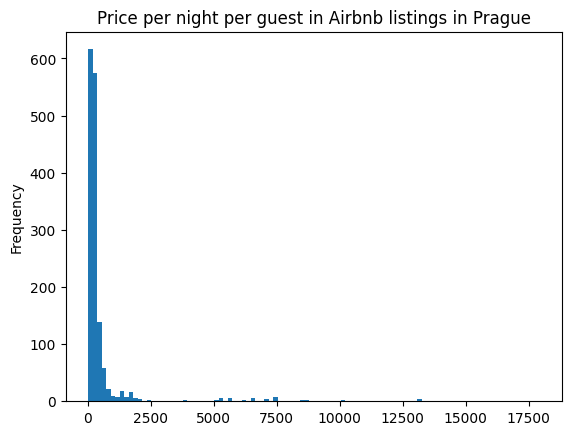

In [19]:
plt.ion()

df['price_per_night_per_guest'].plot(kind='hist', bins=100, title='Price per night per guest in Airbnb listings in Prague')

We can see that the price distribution is indeed heavily skewed by some extremely expensive listings. We can try to look at those listings in more detail to see if they are legitimate or if they are outliers that should be removed from the analysis.

In [29]:
df.sort_values(by='price_per_night_per_guest', ascending=False).head(10)['url']

16               https://www.airbnb.com/rooms/53391894
66                https://www.airbnb.com/rooms/8253514
54               https://www.airbnb.com/rooms/41812654
41     https://www.airbnb.com/rooms/646759591590269458
46     https://www.airbnb.com/rooms/650042649808202329
62               https://www.airbnb.com/rooms/28196448
9                 https://www.airbnb.com/rooms/7147096
26    https://www.airbnb.com/rooms/1056034361609039461
2      https://www.airbnb.com/rooms/585193269877288249
38    https://www.airbnb.com/rooms/1112826933498906863
Name: url, dtype: object

Some of those listings are indeed very expensive - not to point fingers, but they do seem like some borderline money laundering scheme :)

The others are quite unassuming - looking at the prices for soon-to-come dates, it seems like they are just regular listings.

|![Prices for one of the listings in June 2024](./img/airbnb/02_airbnb_smart_pricing_low.png)|
|:--:|
|*Setting the dates to June 2024, there is nothing unusual about the prices for this listing*|

Switching the dates to the December 2024 (we originally collected the data for), we can see that the prices are indeed much higher than usual - this is likely due to the Christmas season, which is a popular time for tourists to visit Prague. This might be caused by the [smart pricing feature of Airbnb](https://www.airbnb.com/help/article/1168), which can adjust the prices based on demand.

|![Prices for one of the listings in December 2024](./img/airbnb/03_airbnb_smart_pricing_high.png)|
|:--:|
|*Setting the dates to December 2024 for the same listing, the prices are much higher than usual*|

Knowing this, we can try to plot the listings on the map again, this time filtering only the listings with a price below a certain threshold.

In [32]:
plt.ioff()

get_map_scale(
    df[df['price_per_night_per_guest'] <= 1000],
    color_attribute='price_per_night_per_guest', 
    scale_label='Price per night per guest (CZK)',
    title='Price per night per guest in Airbnb listings in Prague (<= 1000 CZK)',
    lat_attribute='lat', 
    lon_attribute='lng'
).savefig('./img/airbnb/04_airbnb_price_per_night_per_guest_filter.png', bbox_inches='tight')

| ![Map of Airbnb listings in Prague - price per guest per night (filtered)](./img/airbnb/04_airbnb_price_per_night_per_guest_filter.png) |
|:--:|
|*Map of Airbnb listings in Prague - price per guest per night (filtered)*|

This time, we can clearly see the higher prices for properties in the city center, which is the expected behavior.

With this conclusion, we can move on to the next step where we join the Airbnb data with the other datasets to create a comprehensive dataset for our analysis.

---

[< Back to the main notebook](./index.md)